In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_dir = 'DATaSET_NEW copy/'  # Adjust this path

# Define paths to the training, validation, and test directories
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define image size and batch size
img_height, img_width = 256, 256  # Adjust based on your images
batch_size = 32

# Create training data generator with aggressive data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    zoom_range=0.3,
    shear_range=0.3,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Validation and test data generators (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 18172 images belonging to 2 classes.
Found 10262 images belonging to 2 classes.
Found 19281 images belonging to 2 classes.


In [12]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
with tf.device('/GPU:0'):
    base_model = EfficientNetB0(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
    
    # Unfreeze some of the last layers for fine-tuning
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    # Set callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [16]:
with tf.device('/GPU:0'):
    epochs = 15
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]
    )
    
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 482s 810ms/step - accuracy: 0.6657 - loss: 0.5854 - val_accuracy: 0.4594 - val_loss: 1.0097 - learning_rate: 1.0000e-04
Epoch 2/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 451s 790ms/step - accuracy: 0.8888 - loss: 0.2680 - val_accuracy: 0.9523 - val_loss: 0.1248 - learning_rate: 1.0000e-04
Epoch 3/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 433s 759ms/step - accuracy: 0.9220 - loss: 0.2004 - val_accuracy: 0.9538 - val_loss: 0.1163 - learning_rate: 1.0000e-04
Epoch 4/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 436s 763ms/step - accuracy: 0.9394 - loss: 0.1549 - val_accuracy: 0.9599 - val_loss: 0.1000 - learning_rate: 1.0000e-04
Epoch 5/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 435s 763ms/step - accuracy: 0.9505 - loss: 0.1291 - val_accuracy: 0.9622 - val_loss: 0.1024 - learning_rate: 1.0000e-04
Epoch 6/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 433s 759ms/step - accuracy: 0.9570 - loss: 0.1153 - val_accuracy: 0.9787 - val_loss: 0.0593 - learning_rate: 1.0000e-04
Epoch 7/15
568/568 ━━━━━━━━━━━━━━━━━━━━ 

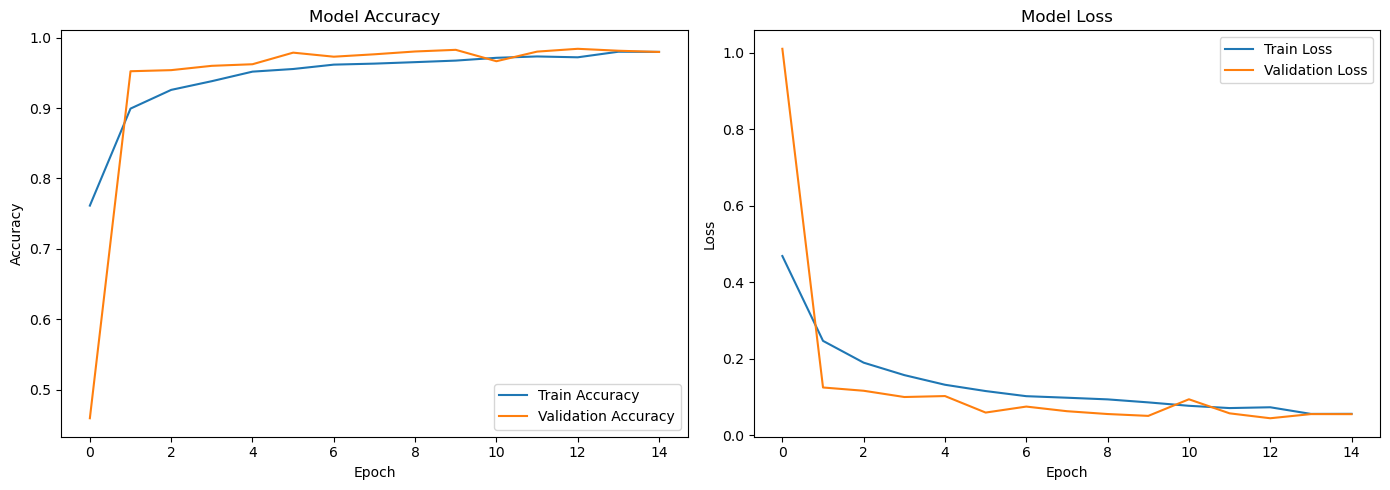

In [17]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
# Save the trained model in .h5 format
model.save("V3_103.h5")
print("Model saved as V3_103.h5")

Model saved as V3_103.h5


In [28]:
model = tf.keras.models.load_model("V3_103.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [30]:
import numpy as np
from PIL import Image

def predict(image):
    # Resize and preprocess the image
    img = image.resize((img_width, img_height))  # Match training dimensions
    img_array = np.array(img) / 255.0  # Normalize the image
    img_array = img_array[np.newaxis, ...]  # Add batch dimension

    # Get predictions
    prediction = model.predict(img_array)[0][0]  # Assuming binary classification
    return {"Class 0": 1 - prediction, "Class 1": prediction}

In [2]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved TensorFlow model
model = tf.keras.models.load_model("V3_103.h5")

# Set the input image dimensions
img_width, img_height = 256, 256  # Updated dimensions to match your images

# Define the prediction function
def predict(image):
    # Resize and preprocess the image
    img = image.resize((img_width, img_height))
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    img_array = img_array[np.newaxis, ...]  # Add batch dimension
    # Predict using the model
    prediction = model.predict(img_array)[0][0]  # Binary classification
    return {"Fake": 1 - prediction, "Real": prediction}

# Create the Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Image"),  # Input: Image
    outputs=gr.Label(num_top_classes=2, label="Predictions"),  # Output: Class probabilities
    title="Deepfake Detection - Group 14",
    description="Upload an image (256x256) to classify it using the V3 model."
)

# Launch the app
interface.launch(share=True)

2024-12-04 19:57:16.781935: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-12-04 19:57:16.781963: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-12-04 19:57:16.781968: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-12-04 19:57:16.782232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-04 19:57:16.782243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://0d75c89cec5249842d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
